# Exploring VXDB

Starter notebook for exploring [virus.exchange](https://virus.exchange), which is [VX Underground](https://www.vx-underground.org/)'s malware repository based on [mwdb.cert.pl](https://mwdb.cert.pl).

# Getting started

Let's start by installing the [`vxdb`](https://github.com/backchannelinc/vxdb) wrapper.

In [ ]:
%pip install git+https://github.com/backchannelinc/vxdb

We then import the library.

In [4]:
from vxdb import VXDB

Now let's get authenticated. We can do that with the CLI with `vxdb login`, or by using the `login()` method.

You could also check if there is an environment variable we could use instead, called `VX_API`, and pass that into the `api_key` argument of the VXDB Class object. But for now, we stick with the `login()` method.

In [6]:
vx = VXDB()
vx.login()

We are now logged in! We can confirm that by doing a count of the repository.

In [32]:
vx.count_files()

10286481

# Putting data into tabular format with `pandas`

Many data scientists use [`pandas`](https://pandas.pydata.org/) for manipulating and analyzing data in Python. We will use it for the similar purpose of taking VXDB data and doing something with it.

First let's install `pandas` and the plotting library `matplotlib`.

In [ ]:
%pip install pandas matplotlib

And we then import the library. We also import some standard stuff like `json`.

In [208]:
import pandas as pd
import json
import itertools

ModuleNotFoundError: No module named 'matplotlib'

We need some idea of the data and what it looks like so we know how it should be tabulated by `pandas`.

Since we are just exploring, let's start looking at some of the most recent files.

In [71]:
recent_files = vx.recent_files()
most_recent_file = next(recent_files)
most_recent_file.name

'Trojan.Win32.MicroFake.ba-1fc1cd22918ef9b0d19165edb903dc709f1cc84d356e91d3056f681a7b5ca884'

Soooooooo I kind of what a method to just dump all the available metdata about the file as a Python `dict`.

In [133]:
def sample_info(sample: vxdb.file.MWDBFile):
    return {
        'id': sample.id,
        'upload_time': str(sample.upload_time),
        'name': sample.name,
        'file_name': sample.file_name,
        'file_type': sample.file_type,
        'size': sample.size,
        'type': sample.type,
        'tags': sample.tags,
        'analyses': [{'id':analysis.id,'status':analysis.status,'is_running':analysis.is_running,'arguments':analysis.arguments,'processing_in':analysis.processing_in} for analysis in sample.analyses],
        # NOTE: couldn't add analysis.last_update because of some stupid error in mwdb: "TypeError: fromisoformat: argument must be str"
        'parents': sample.parents,
        'children': sample.children,
        'comments': sample.comments,
        'object_type': sample.object_type,
        'shares': [{'timestamp':str(share.timestamp),'group':share.group,'reason':str(share.reason)} for share in sample.shares]
    }

Now let's run that over our sample.

In [134]:
sample_info(most_recent_file)

{'id': '1fc1cd22918ef9b0d19165edb903dc709f1cc84d356e91d3056f681a7b5ca884',
 'upload_time': '2022-07-27 03:14:42.028353+00:00',
 'name': 'Trojan.Win32.MicroFake.ba-1fc1cd22918ef9b0d19165edb903dc709f1cc84d356e91d3056f681a7b5ca884',
 'file_name': 'Trojan.Win32.MicroFake.ba-1fc1cd22918ef9b0d19165edb903dc709f1cc84d356e91d3056f681a7b5ca884',
 'file_type': 'PE32 executable (DLL) (GUI) Intel 80386, for MS Windows',
 'size': 87628,
 'type': 'PE32 executable (DLL) (GUI) Intel 80386, for MS Windows',
 'tags': ['yara:win_files_operation',
  'yara:ispe32',
  'yara:iswindowsgui',
  'yara:win_mutex',
  'runnable:win32:dll',
  'yara:hasoverlay',
  'yara:hasrichsignature',
  'yara:isdll',
  'virusshare084'],
 'analyses': [{'id': 'a0e63a4b-926a-4e4f-95ad-082fd4f797d4',
   'status': 'finished',
   'is_running': False,
   'arguments': {},
   'processing_in': {}}],
 'parents': [],
 'children': [],
 'comments': [],
 'object_type': 'file',
 'shares': [{'timestamp': '2022-07-27 03:14:42.098263+00:00',
   'gro

NOTE: It turns our the `.data` property actually would have just done some of this (not all of it).

# Generating stats from a query

Ok we are getting warmed up. Let's now try querying for something, then extracting some stats from the results.

Let's do everything in the past week. And let's use our function for parsing out metadata.

In [162]:
QUERY = '''upload_time:["2022-07-19 00:00" TO "2022-07-27 00:00"]'''
result = vx.search_files(QUERY)

Because the API only returns the result as an `Iterator`, we unfortunately can't just run `len(result)`. We're going to have to page through the results (annoying!).

Here are the first 25 samples

In [178]:
[sample.data for sample in itertools.islice(result,25)]

[{'tags': [{'tag': 'virusshare084'},
   {'tag': 'yara:check_outputdebugstringa_iat'},
   {'tag': 'yara:iswindowsgui'},
   {'tag': 'yara:microsoft_visual_basic_v50'},
   {'tag': 'yara:isdll'},
   {'tag': 'yara:seh_init'},
   {'tag': 'yara:network_dropper'},
   {'tag': 'yara:suspicious_packer_section'},
   {'tag': 'yara:win_private_profile'},
   {'tag': 'runnable:win32:dll'},
   {'tag': 'yara:hasoverlay'},
   {'tag': 'yara:hasrichsignature'},
   {'tag': 'yara:str_win32_http_api'},
   {'tag': 'yara:screenshot'},
   {'tag': 'yara:win_files_operation'},
   {'tag': 'yara:ispe32'},
   {'tag': 'yara:str_win32_wininet_library'},
   {'tag': 'yara:vmprotect_1704_phpbb3'},
   {'tag': 'yara:anti_dbg'}],
  'file_name': 'Trojan-PSW.Win32.Kykymber.dotw-7b81d14b7ebcac76aaac79f070f7492f3fd46251ad94934d157c22db0156d005',
  'file_type': 'PE32 executable (DLL) (GUI) Intel 80386, for MS Windows',
  'upload_time': '2022-07-27T00:00:15.988553+00:00',
  'sha256': '7b81d14b7ebcac76aaac79f070f7492f3fd46251ad9493

So let's say we want to see the top tags from a subset of data, say the first 1000.

In [204]:
list_of_tag_lists = [[tag['tag'] for tag in sample.data['tags']] for sample in itertools.islice(result,1000)]

In [205]:
all_tags = []
for taglist in list_of_tag_lists:
    for tag in taglist:
        all_tags.append(tag)
all_tags

['yara:base64_table',
 'yara:borland_delphi_30_additional',
 'yara:borland_delphi_v30',
 'yara:borland_delphi_v60_v70',
 'yara:screenshot',
 'yara:win_files_operation',
 'virusshare084',
 'yara:bobsoft_mini_delphi_bob_bobsoft_additional',
 'yara:borland_delphi_v40_v50',
 'yara:bobsoftminidelphibobbobsoft',
 'yara:borland',
 'yara:keylogger',
 'runnable:win32:exe',
 'yara:borland_delphi',
 'yara:borland_delphi_40',
 'yara:borland_delphi_dll',
 'yara:ispe32',
 'yara:anti_dbg',
 'yara:win_registry',
 'yara:borland_delphi_30_',
 'yara:borland_delphi_40_additional',
 'yara:borland_delphi_setup_module',
 'yara:delphi_comparecall',
 'yara:delphi_formshow',
 'yara:iswindowsgui',
 'yara:microsoft_visual_cpp_v50v60_mfc',
 'yara:win_hook',
 'yara:seh_init',
 'virusshare084',
 'runnable:win32:dll',
 'yara:debuggerexception__setconsolectrl',
 'yara:visual_cpp_2003_dll_microsoft',
 'yara:win_files_operation',
 'yara:ispe32',
 'yara:isdll',
 'yara:iswindowsgui',
 'yara:anti_dbg',
 'yara:hasrichsignat

Now we can finally put into a `DataFrame`.

In [206]:
df = pd.DataFrame({'tags':all_tags})
df

,tags
0,yara:base64_table
1,yara:borland_delphi_30_additional
2,yara:borland_delphi_v30
3,yara:borland_delphi_v60_v70
4,yara:screenshot
...,...
22613,yara:ispe32
22614,yara:pecompact_253_dll_bitsum_technologies
22615,yara:seh_init
22616,yara:screenshot


Woooo! now doing stuff is easy. Let's group by tag.

In [241]:
df_group_by_tag = df.groupby('tags').size().sort_values(ascending=False).reset_index(name='volume')
df_group_by_tag


,tags,volume
0,virusshare084,1000
1,yara:ispe32,996
2,yara:iswindowsgui,991
3,yara:hasrichsignature,686
4,runnable:win32:dll,614
...,...,...
414,yara:nspackv31northstar,1
415,yara:nspackv34v35liuxingping,1
416,yara:ntkrnlpackerashkbizdanehkar,1
417,yara:ntkrnlsecuresuite01015ntkrnlsoftware,1


It makes sense the top volume for `virusshare084` is 1000, which what the size of the subset population we took from the `Iterator`. Because they're such outliers, let's cut out those top 3 tags.

In [ ]:
%pip install altair

In [301]:
import altair as alt


In [303]:
alt.Chart(df_group_by_tag[4:1000]).mark_bar().encode(
    x='tags',
    y='volume'
)

AttributeError: 'Chart' object has no attribute 'bar'

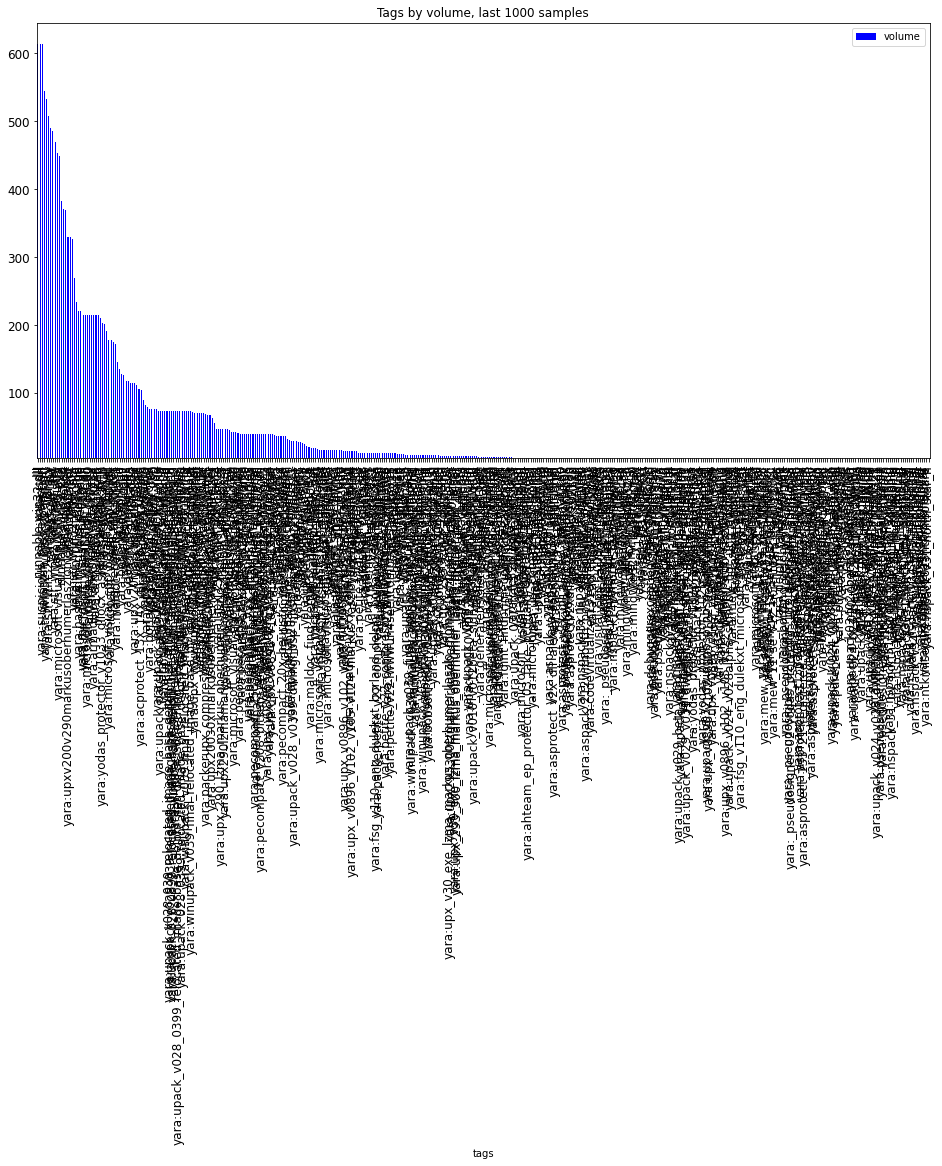

In [298]:
ax = df_group_by_tag[4:1000].plot.bar(
    x='tags',
    y='volume',
    color='blue',
    fontsize=12,
    legend=True,
    figsize=(16,8),
    xlim=5,
    ylim=5,
    title='Tags by volume, last 1000 samples'
)